# Notebook to match VASCA sources to SIMBAD database sources positionally
Set your option in the cell bellow

In [1]:
from astropy import units as uu
region_name = "TDS" # _ELAISN1
simbad_query = False
radius = 5 * uu.arcsec

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord
from astropy.table import unique, Table
import numpy as np
from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
from vasca.tables import TableCollection, dd_vasca_columns
from vasca.utils import otype2ogroup,dd_ogrp2otypes
from astroquery.simbad import Simbad
from itertools import cycle
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["0.8","b",'r', 'g', 'k', 'y',"m","c"])


#prepare file names
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
simbad_fname = "./vasca_pipeline/"+region_name+"/simbad_"+region_name+".fits"

#Simbad.get_field_description('otype')

### Query the data or read from file

In [3]:
# Get region and source coordinates
rg = Region()
rg.load_from_fits(region_fname)
rg.set_hardness_ratio() # Remove this later when included in standard pipeline
sel_src = rg.tt_sources["sel"]
tt_src = rg.tt_sources[sel_src]

# Get matches
mt = TableCollection()
if simbad_query:
    # Run query
    src_coord = SkyCoord(tt_src["ra"].quantity,tt_src["dec"].quantity,frame='icrs')
    customSimbad = Simbad()
    customSimbad.add_votable_fields('otype',"otype(opt)","otypes")
    tt_simbad = customSimbad.query_region(src_coord,radius=radius)
    
    # Change type to be handabel by astropy
    tt_simbad["MAIN_ID"] = tt_simbad["MAIN_ID"].data.astype("S32")
    tt_simbad["COO_BIBCODE"] = tt_simbad["COO_BIBCODE"].data.astype("S32")
    tt_simbad["OTYPE"] = tt_simbad["OTYPE"].data.astype("S32")
    tt_simbad["OTYPE_opt"] = tt_simbad["OTYPE_opt"].data.astype("S32")
    tt_simbad["OTYPES"] = tt_simbad["OTYPES"].data.astype("S32")

    # Write simbad and source info into matching tables
    src_idx = tt_simbad["SCRIPT_NUMBER_ID"]-1
    tt_simbad["rg_src_id"] = tt_src[src_idx]["rg_src_id"]
    tt_simbad["match_id"] = np.array(range(0,len(tt_simbad)), dtype= np.int32)

    #Create association table
    tt_match = Table(tt_src["rg_src_id","ra","dec","pos_err","obs_filter_id","sel","flux","flux_err","flux_nxv","hr","hr_err"])
    tt_match.meta["rad"]=str(radius)

    # Add tables to table collection and write
    mt.add_table(tt_match,"tt_match")
    mt.add_table(tt_simbad,"tt_simbad")

    #Get SIMBAD table with the closest match
    tu_simbad = unique(tt_simbad, keys='SCRIPT_NUMBER_ID')
    display(tt_simbad[:2])

    #Add columns to be filled
    otype = np.array([dd_vasca_columns["otype"]["default"]]*len(tt_match), dtype=dd_vasca_columns["otype"]["dtype"])
    mt.add_column("tt_match","otype",otype)
    otype = np.array([dd_vasca_columns["match_id"]["default"]]*len(tt_match), dtype=dd_vasca_columns["match_id"]["dtype"])
    mt.add_column("tt_match","match_id",otype)

    #Copy information into mt.tt_match table
    mt.tt_match.add_index("rg_src_id")
    mt_idx = mt.tt_match.loc_indices["rg_src_id", tu_simbad["rg_src_id"]]
    mt.tt_match["otype"][mt_idx] = tu_simbad["OTYPE_opt"]
    mt.tt_match["match_id"][mt_idx] = tu_simbad["match_id"]
 
    #Write collectiion
    mt.write_to_fits(simbad_fname)
else:
    #Load collection
    mt.load_from_fits(simbad_fname)    
    
# Add object group ID
def add_ogrp(tc,tt_name):
    "Helper funtion to add ogrp:id column to tables"
    tt = tc.__dict__[tt_name]
    tc.add_column(tt_name,"ogrp")
    for ii in range(len(tt)):
        tt["ogrp"][ii] = otype2ogroup(tt["otype"][ii])
add_ogrp(mt,"tt_match")
display(mt.tt_match[:2])  

rg_src_id,ra,dec,pos_err,obs_filter_id,sel,flux,flux_err,flux_nxv,hr,hr_err,otype,match_id,ogrp
,deg,deg,arcsec,,,1e-06 Jy,1e-06 Jy,,,,,,
int32,float64,float64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32,float32,bytes32,int32,bytes8
8,334.64049826925117,0.4526866937010489,0.09875569,1 .. 2,True,9.525185 .. 5.7065663,0.13788767 .. 0.29823554,0.036390573 .. 0.013060489,0.5453358,0.040161453,QSO,0,AGN
13,334.60403128211425,0.40736589666436374,0.06406002,1 .. 2,True,70.01522 .. 3.1264899,0.19698732 .. 0.23375492,0.00093811314 .. 0.013469439,0.0428149,0.0032296947,QSO,1,AGN


### Plot found object types

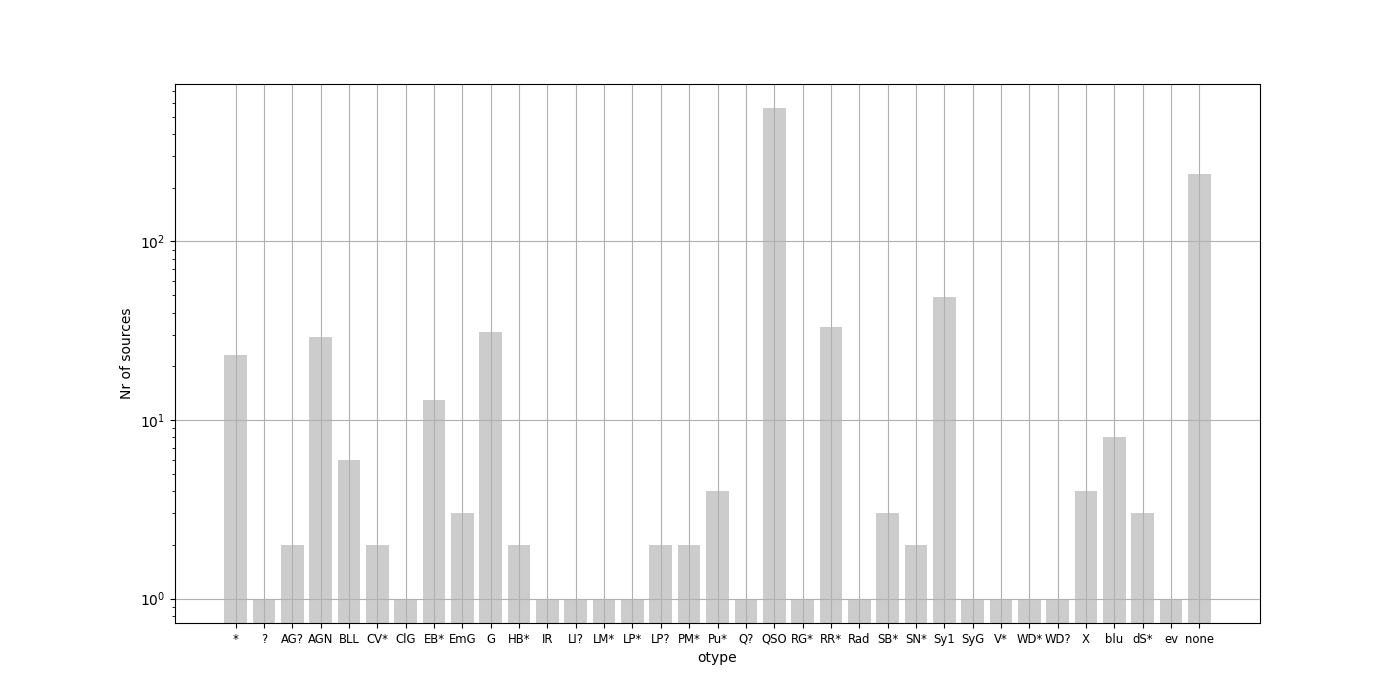

otype    Label     Candidate         Description                            Category                                          Subcategory                                            Comment                   Status Priority ogrp
                                                                                                                                                                                                                                   
----- ------------ --------- ---------------------------- ------------------------------------------- ------------------------------------------------------------ ------------------------------------------- ------ -------- ----
    ?      Unknown        --     Object of Unknown Nature 8. BLENDS, ERRORS, NOT WELL DEFINED OBJECTS                                                           --                                          --     --       --  UNK
    *         Star        --                         Star                        1. TAXO

In [4]:
otypes, otype_cts= np.unique(mt.tt_match["otype"],return_counts=True)
fig_otypes = plt.figure("Source types",figsize=(14, 7))
plt.bar( range(len(otypes)), otype_cts, align='center')
plt.xticks(range(len(otypes)), otypes, size='small')
plt.yscale('log')
plt.grid()
plt.xlabel("otype")
plt.ylabel("Nr of sources")
plt.show()

tt_nodes = Table.read('./resources/SIMBAD_otypes/otypes_nodes.csv') #, format='ascii.daophot'
ids, ids_idx, _ = np.intersect1d(tt_nodes["Id"],otypes,return_indices=True)
candidate = np.asarray(np.ma.masked_array(data = tt_nodes["Candidate"],mask = False, fill_value = "none"))
can, can_idx, _ = np.intersect1d(candidate,otypes,return_indices=True)
all_idx = np.unique(np.append(ids_idx,can_idx))
tt_nodes.rename_column('Id', 'otype')
mt.add_table(tt_nodes[all_idx],"tt_otypes")
add_ogrp(mt,"tt_otypes")
mt.tt_otypes.pprint_all()#show_dtype=True

### Scatter plots of source variables by group

dict_keys(['UNK', 'AGN', 'GAL', 'STA', 'WD', 'PMS', 'CV', 'BS', 'LEI', 'SN'])


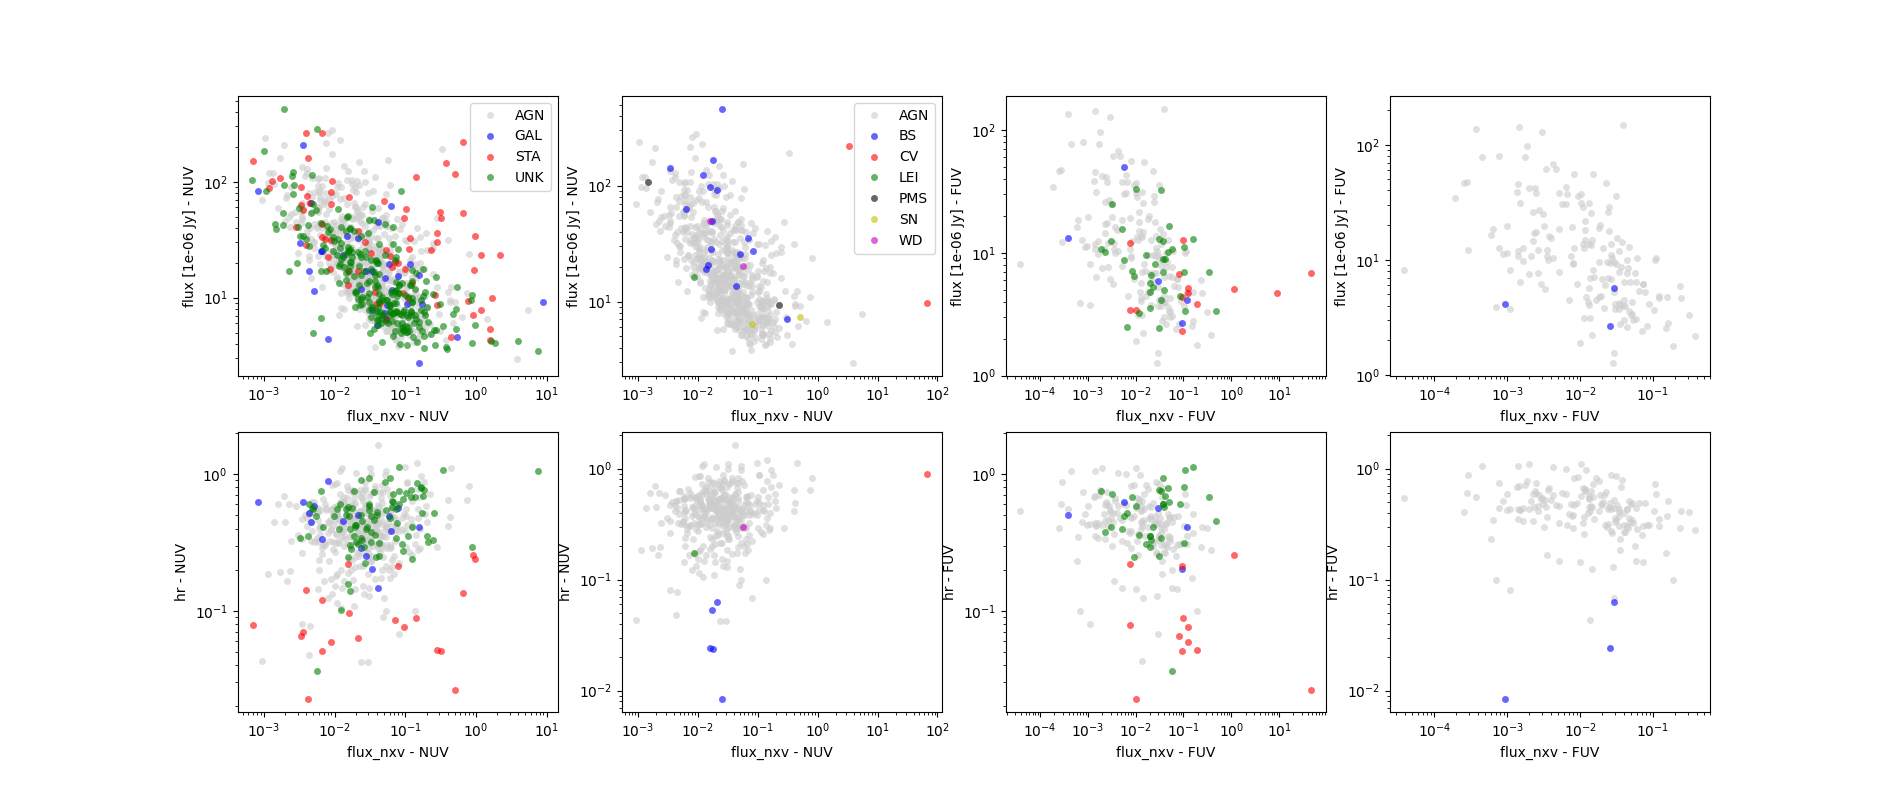

In [5]:
plot_kwargs = {"markersize": 5.0,"alpha":0.6}
fig, axs = plt.subplots(2, 4, figsize=(19, 8))
axs = axs.flatten()
plt_ogrops = [["AGN","GAL","UNK",'STA'],["AGN",'WD', 'VS', 'PMS', 'CV', 'BS', 'LEI', 'SN']]
plt_flts = [1,2]
ctr = 0
for flt in plt_flts:
    for ogrps in plt_ogrops:
        vvis.plot_table_scatter(mt.tt_match,"flux_nxv", "flux", ax=axs[ctr], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp",grp_vals = ogrps,**plot_kwargs)
        vvis.plot_table_scatter(mt.tt_match,"flux_nxv", "hr", ax=axs[ctr+4], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp",grp_vals = ogrps,**plot_kwargs)
        ctr +=1
_ = axs[0].legend()
_ = axs[1].legend()
print(dd_ogrp2otypes.keys())

### Print info for selected sources

In [9]:
# Make selection
sel_otype = mt.tt_match["otype"] ==  "LI?" # "SN*" #"EB*"
sel_flux_nxv_fuv = mt.tt_match["flux_nxv"][:,1]>1
sel_srcs = sel_flux_nxv_fuv

#Display match and simbad table for selected sources
display(mt.tt_match[sel_srcs])
mt.tt_simbad.add_index("match_id")
tt_simbad_sel =  mt.tt_simbad.loc[mt.tt_match[sel_srcs]["match_id"]]
display(tt_simbad_sel)

#Print oout list of source IDs to be used for further use, e.g. in inspect_sources.ipynb
print("srcs_ids = [", end="")
for src_id in mt.tt_match[sel_srcs]["rg_src_id"].data:
    print(src_id,",", end="")
print("]")

rg_src_id,ra,dec,pos_err,obs_filter_id,sel,flux,flux_err,flux_nxv,hr,hr_err,otype,match_id,ogrp
,deg,deg,arcsec,,,1e-06 Jy,1e-06 Jy,,,,,,
int32,float64,float64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32,float32,bytes32,int32,bytes8
2052,333.83276369023395,1.6990072104081713,0.12848786,1 .. 2,True,17.56579 .. 4.724349,0.21717925 .. 0.5637285,0.09769247 .. 8.875739,-1.0,-1.0,RR*,43,STA
15179,150.38873296492392,1.7245661255048343,0.091720134,1 .. 2,True,115.98597 .. 6.914319,0.36588797 .. 0.48867714,0.51384246 .. 47.295803,0.02655312,0.0027632199,RR*,322,STA
15934,150.1707814182824,1.3683013651130953,0.1590582,1 .. 2,True,7.031118 .. 5.0570483,0.18787879 .. 0.561429,0.9210728 .. 1.1674414,0.2569302,0.029988198,RR*,334,STA


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,OTYPE,OTYPE_opt,OTYPES,SCRIPT_NUMBER_ID,rg_src_id,match_id
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,,
bytes32,bytes13,bytes13,int16,int16,float32,float32,int16,bytes1,bytes1,bytes32,bytes32,bytes32,bytes32,int32,int32,int32
CRTS J221519.8+014157,22 15 19.8745,+01 41 56.241,14,14,0.086,0.085,90,A,O,2020yCat.1350....0G,RRLyrae,RR*,RR*|RR*|*|RR?,46,2052,43
LINEAR 21145823,10 01 33.2594,+01 43 28.498,14,14,0.033,0.041,90,A,O,2020yCat.1350....0G,RRLyrae,RR*,RR*|RR*|RR*|RR*|RR*|RR*|RR*|Pu*|,344,15179,322
SDSS J100040.95+012205.6,10 00 40.9607,+01 22 05.671,14,14,0.217,0.215,90,A,O,2020yCat.1350....0G,RRLyrae,RR*,RR*|RR*|RR*|RR*|RR*|RR*|*|*|Opt|,357,15934,334


srcs_ids = [2052 ,15179 ,15934 ,]


Identified sources:
1) 150.38873296492392	1.7245661255048343; GNU2605264352416104448 PS_COSMOS_MOS26; LINEAR 21145823;RR*;Very large flux_nxv_fuv=47 and very low hr 0.026; 